# Droid PaliGemma SAE Training on Language Layer

### Import libraries and define SAE class

In [4]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1,2"

# this is to only use GPUs 1 and 2

import torch
import tensorflow as tf
import tensorflow_datasets as tfds
from concurrent.futures import ThreadPoolExecutor
from torchvision.utils import make_grid
import requests
from transformers import AutoProcessor, PaliGemmaForConditionalGeneration
from datasets import load_dataset
from torch import nn, Tensor
from torch.utils.data import DataLoader, Subset
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import gc
import wandb
from datetime import datetime
import torch.nn as nn
from torch.cuda.amp import autocast
import multiprocessing
from datasets import Dataset
import numpy as np
from PIL import Image
from IPython import display

DIM_IN = 2048
DIM_HIDDEN = 4096

class SparseAutoencoder(nn.Module):
    def __init__(self, d_in=DIM_IN, d_hidden=DIM_HIDDEN):
        super().__init__()
        self.encoder = nn.Linear(d_in, d_hidden)
        self.activation = nn.ReLU()
        self.decoder = nn.Linear(d_hidden, d_in)

    def forward(self, x):
        z = self.activation(self.encoder(x))
        x_recon = self.decoder(z)
        return x_recon, z

device = "cuda:1" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

dtype = torch.float16

Using device: cuda:1


### Loading DROID dataset
This is 20 frames from each of the 100 episodes.
Saved previously as "droid_100episodes_20frames.pt"

In [2]:
class DroidDataset(torch.utils.data.Dataset):
    def __init__(self, path="droid_100episodes_20frames.pt"):
        data = torch.load(path)
        self.images = data["images"]
        self.prompts = data["prompts"]

    def __len__(self):
        return len(self.prompts)

    def __getitem__(self, idx):
        return {
            "image": self.images[idx],
            "prompt": self.prompts[idx]
        }

# Usage
dataset = DroidDataset()

/tmp/ipykernel_456473/2961503011.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(path)


### Load model (takes 55 seconds)

In [2]:
MODEL_ID = "google/paligemma-3b-mix-224"

model = PaliGemmaForConditionalGeneration.from_pretrained(
    MODEL_ID,
    torch_dtype=dtype
).eval()
model = model.to(device) # Move model to GPU
processor = AutoProcessor.from_pretrained(MODEL_ID)

NameError: name 'PaliGemmaForConditionalGeneration' is not defined

In [1]:
for name, module in model.named_modules():
    if "langauge" in name:
        print(name)

NameError: name 'model' is not defined

In [9]:
# language layer 
language_acts = {}

def language_hook(module, input, output):
    language_acts["activation"] = output.detach().cpu()

# === Config ===
BATCH_SIZE = 16 # max size withou OOM error
NUM_WORKERS = 8

def collate_fn(batch):
    images = [example["image"] for example in batch]
    prompts = [example["prompt"] for example in batch]
    return {"images": images, "prompts": prompts}

# === Split dataset across 2 GPUs ===
half = len(dataset) // 2
datasets = [Subset(dataset, range(0, half)), Subset(dataset, range(half, len(dataset)))]
devices = ["cuda:1", "cuda:2"]
activation_lists = [[], []]
token_counts = [[], []]

# === Inference function ===
def run_inference(model, dataloader, device, activations_out, token_counts_out):
    model = model.to(device).eval()
    for batch in tqdm(dataloader, desc=f"Inference on {device}"):
        try:
            images = batch["images"]
            prompts = batch["prompts"]

            model_inputs = processor(
                text=prompts,
                images=images,
                return_tensors="pt",
                padding=True
            )
            model_inputs = {k: v.to(device, non_blocking=True) for k, v in model_inputs.items()}

            with torch.no_grad(), autocast(dtype=torch.bfloat16):
                _ = model(**model_inputs)

            act = language_acts["activation"]
            if isinstance(act, tuple):
                act = act[0]

            activations_out.append(act.cpu().float())
            token_counts_out.extend([act.shape[1]] * act.size(0))
        except Exception as e:
            print(f"Skipping batch due to error on {device}: {e}")
            continue

# === Run in parallel across both GPUs ===
from threading import Thread

dataloaders = [
    DataLoader(datasets[0], batch_size=BATCH_SIZE, collate_fn=collate_fn,
               num_workers=NUM_WORKERS, pin_memory=True),
    DataLoader(datasets[1], batch_size=BATCH_SIZE, collate_fn=collate_fn,
               num_workers=NUM_WORKERS, pin_memory=True)
]

# Clone model and hook separately for each GPU
import copy
models = [copy.deepcopy(model), copy.deepcopy(model)]

# Register hooks on both models (if needed)
hook_handles = []
for i, m in enumerate(models):
    h = m.language_model.model.layers[17].mlp.register_forward_hook(language_hook)
    hook_handles.append(h)

# Launch threads
threads = []
for i in range(2):
    t = Thread(target=run_inference, args=(
        models[i], dataloaders[i], devices[i], activation_lists[i], token_counts[i]))
    t.start()
    threads.append(t)

for t in threads:
    t.join()

# Remove hooks
for h in hook_handles:
    h.remove()

# === Merge results ===
all_activations = torch.cat(activation_lists[0] + activation_lists[1], dim=0)
image_to_token_counts = token_counts[0] + token_counts[1]

if all_activations.size(0) == 0:
    raise ValueError("No valid activations collected!")

print("Collected activations:", all_activations.shape)
print("Sum of tokens recorded:", sum(image_to_token_counts))

# Clean up memory
del models, hook_handles, activation_lists, token_counts, datasets, dataloaders, fusion_acts
gc.collect()
torch.cuda.empty_cache()

OutOfMemoryError: CUDA out of memory. Tried to allocate 64.00 MiB. GPU 1 has a total capacity of 39.49 GiB of which 25.81 MiB is free. Process 452831 has 18.03 GiB memory in use. Including non-PyTorch memory, this process has 21.42 GiB memory in use. Of the allocated memory 20.73 GiB is allocated by PyTorch, and 199.47 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

### Save to disk

In [11]:
# Convert to half precision before saving (cuts size in half)
all_activations_fp16 = all_activations.half()
torch.save(all_activations_fp16, "all_activations_fp16.pt")
torch.save(image_to_token_counts, "image_to_token_counts.pt")

### Train SAE

In [12]:
# === Initialize Weights & Biases ===
wandb.init(project="sparse-autoencoder", name="SAE-run", config={
    "hidden_multiplier": 8,
    "learning_rate": 1e-4,
    "sparsity_weight": 1e-2,
    "n_epochs": 50,
    "batch_size": 128,
})

# === Hyperparameters ===
hidden_multiplier = wandb.config.hidden_multiplier
learning_rate = wandb.config.learning_rate
sparsity_weight = wandb.config.sparsity_weight
n_epochs = wandb.config.n_epochs
batch_size = wandb.config.batch_size

# === Prepare SAE ===
d_in = all_activations.shape[-1]
d_hidden = hidden_multiplier * d_in

sae = SparseAutoencoder(d_in=d_in, d_hidden=d_hidden).to("cuda:0") 
sae = nn.DataParallel(sae)  # Now wrap for multi-GPU
optimizer = torch.optim.AdamW(sae.parameters(), lr=learning_rate)
loss_fn = nn.MSELoss()

# === Dataset & Loader ===
train_dataset = torch.utils.data.TensorDataset(all_activations)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

wandb: Currently logged in as: htsai (htsai2025) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


/home/henrytsai/anaconda3/envs/safaa/lib/python3.10/site-packages/torch/nn/modules/linear.py:125: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return F.linear(input, self.weight, self.bias)


Epoch 5: Loss 0.015509
Epoch 10: Loss 0.007394
Epoch 15: Loss 0.004987
Epoch 20: Loss 0.003834
Epoch 25: Loss 0.003153
Epoch 30: Loss 0.002646
Epoch 35: Loss 0.002283
Epoch 40: Loss 0.002010
Epoch 45: Loss 0.001797
Epoch 50: Loss 0.001652
Finished training Sparse Autoencoder!
Saved SAE to checkpoints/sae_2025-05-04_02-05-37.pth


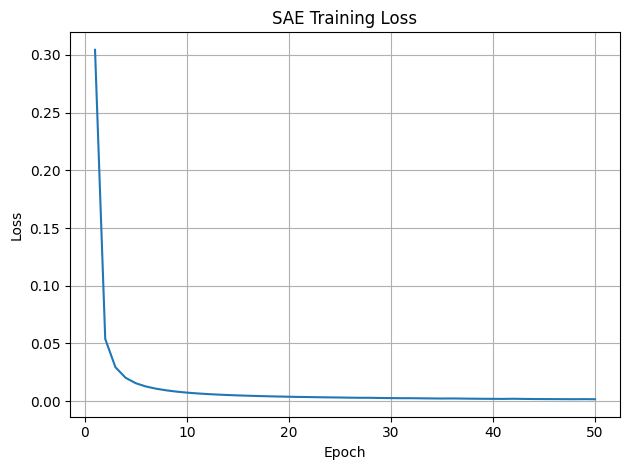

In [13]:
epoch_losses = []

for epoch in range(n_epochs):
    epoch_loss = 0.0
    for batch, in train_loader:
        batch = batch.to("cuda:0", non_blocking=True)
        recon, z = sae(batch)

        loss = loss_fn(recon, batch) + sparsity_weight * torch.mean(torch.abs(z))
        epoch_loss += loss.item() * batch.size(0)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avg_loss = epoch_loss / len(train_dataset)
    epoch_losses.append(avg_loss)

    # Log to wandb every epoch
    wandb.log({"loss": avg_loss, "epoch": epoch + 1})

    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}: Loss {avg_loss:.6f}")

print("Finished training Sparse Autoencoder!")

# === Save model with timestamp ===
save_dir = "checkpoints"
os.makedirs(save_dir, exist_ok=True)

timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
model_path = os.path.join(save_dir, f"sae_{timestamp}.pth")

torch.save({
    "state_dict": sae.state_dict(),
    "d_in": d_in,
    "d_hidden": d_hidden,
}, model_path)
wandb.save(model_path)

print(f"Saved SAE to {model_path}")

# === Plot loss curve (optional) ===
plt.plot(range(1, n_epochs + 1), epoch_losses, label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("SAE Training Loss")
plt.grid(True)
plt.tight_layout()
wandb.log({"loss_curve": wandb.Image(plt)})
plt.show()

In [14]:
print(model.multi_modal_projector.linear)
print(all_activations.shape[-1])

Linear(in_features=1152, out_features=2048, bias=True)
2048


### Load previously trained model

In [20]:
# Need to change model path to your own local folder and .pth filename
# model_path = "/home/henrytsai/safaa/roboterp/checkpoints/sae_2025-05-04_01-28-59.pth"

# === Initialize Weights & Biases ===
wandb.init(project="sparse-autoencoder", name="SAE-run", config={
    "hidden_multiplier": 8,
    "learning_rate": 1e-4,
    "sparsity_weight": 1e-2,
    "n_epochs": 50,
    "batch_size": 512,
})

# === Hyperparameters ===
hidden_multiplier = wandb.config.hidden_multiplier
learning_rate = wandb.config.learning_rate
sparsity_weight = wandb.config.sparsity_weight
n_epochs = wandb.config.n_epochs
batch_size = wandb.config.batch_size

# ==== LOAD METADATA ====
image_to_token_counts = torch.load("image_to_token_counts.pt")
all_activations = torch.load("all_activations_fp16.pt", map_location="cpu")  # shape: [N_images, T, D]
all_activations = all_activations.view(-1, all_activations.shape[-1])        # -> [N_tokens, D]

d_in = all_activations.shape[-1]
d_hidden = hidden_multiplier * d_in

# Define the model
sae = SparseAutoencoder(d_in=d_in, d_hidden=d_hidden)
state_dict = torch.load(model_path, map_location=device)["state_dict"]

# If saved with DataParallel, strip 'module.' prefix
from collections import OrderedDict
if any(k.startswith("module.") for k in state_dict):
    new_state_dict = OrderedDict((k.replace("module.", ""), v) for k, v in state_dict.items())
    state_dict = new_state_dict

# Apply weights
sae.load_state_dict(state_dict)
sae = sae.to(device)
sae.eval()

# Setup SAE model
sae_device = sae.encoder.weight.device
sae_dtype = sae.encoder.weight.dtype

/tmp/ipykernel_230596/1034059765.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  image_to_token_counts = torch.load("image_to_token_counts.pt")
/tmp/ipykernel_230596/10

In [21]:
checkpoint = torch.load(model_path)
assert checkpoint["d_in"] == d_in, "Incompatible d_in!"
assert checkpoint["d_hidden"] == d_hidden, "Incompatible d_hidden!"

/tmp/ipykernel_230596/3548018434.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


### Visualize features

Top 15 active features: [1339, 12895, 15867, 15095, 11932, 7321, 5772, 2402, 11155, 4972, 14463, 3570, 2526, 4263, 12593]


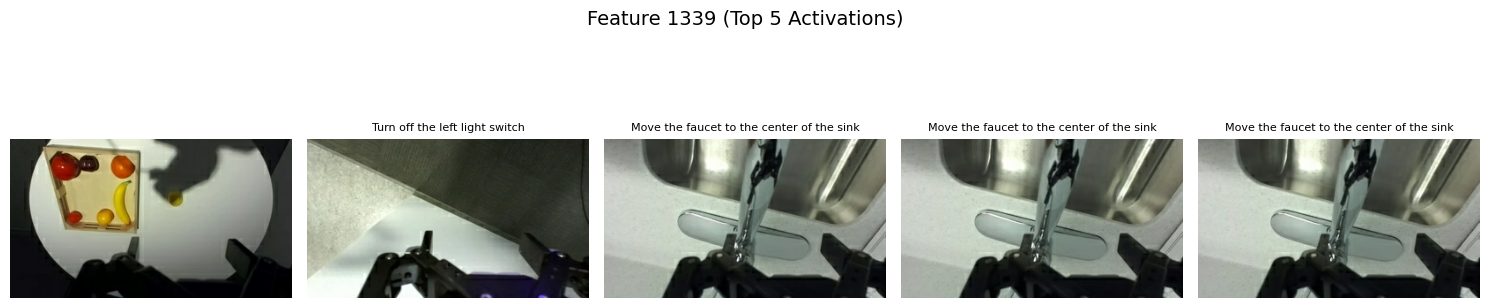

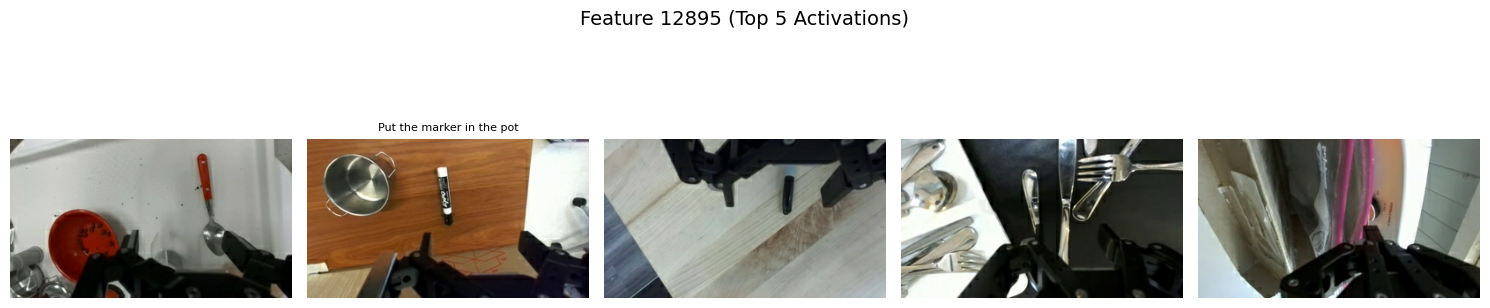

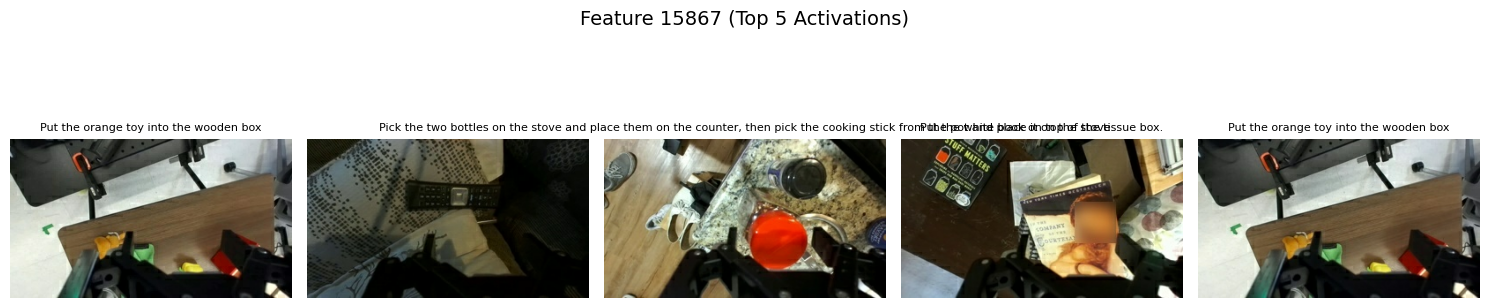

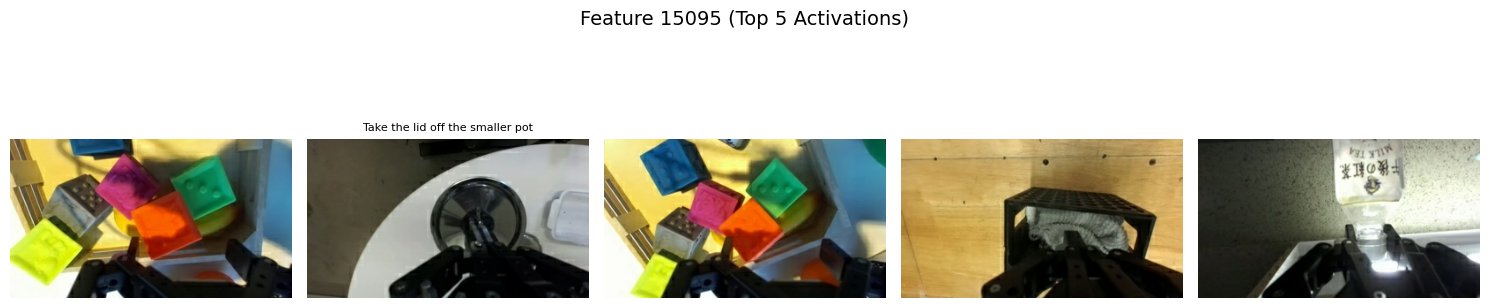

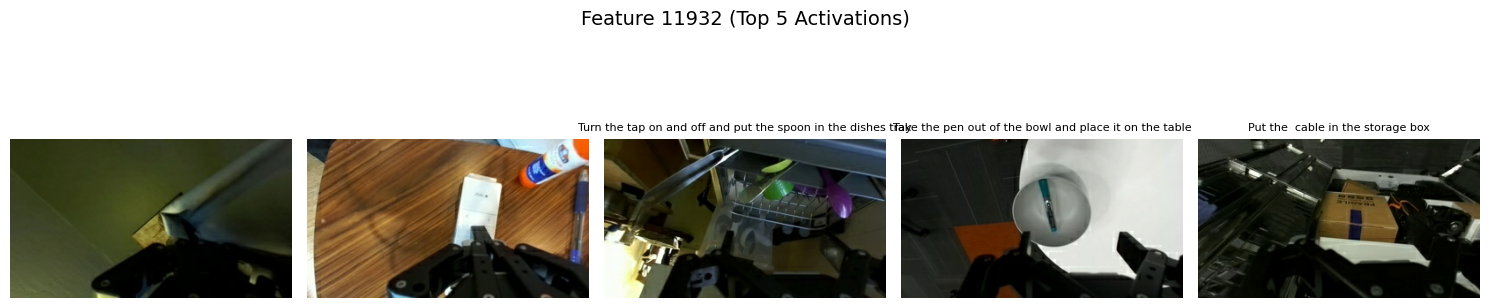

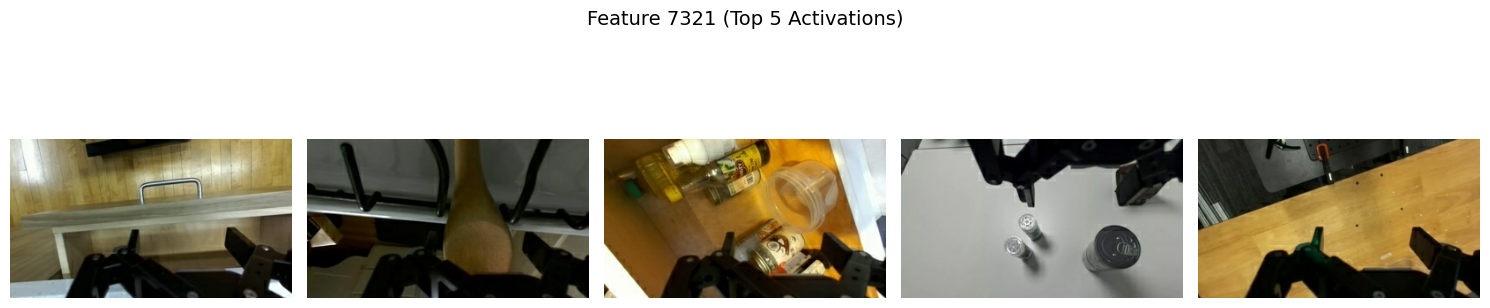

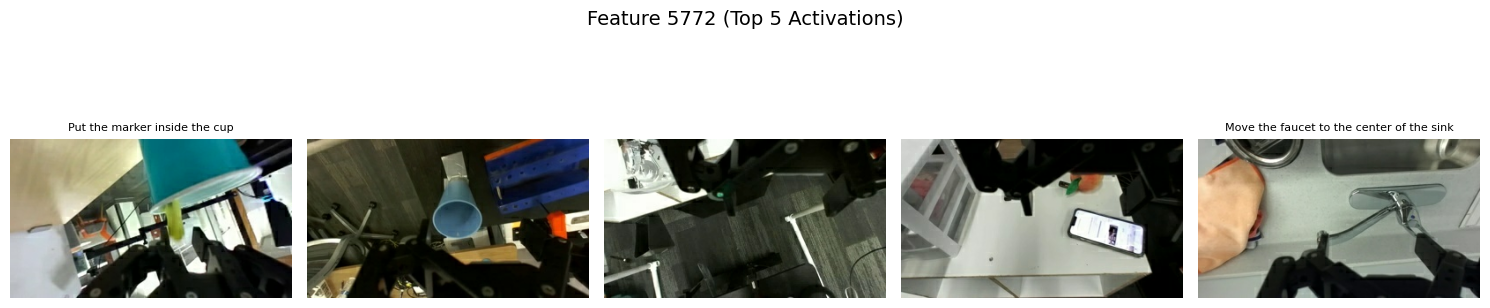

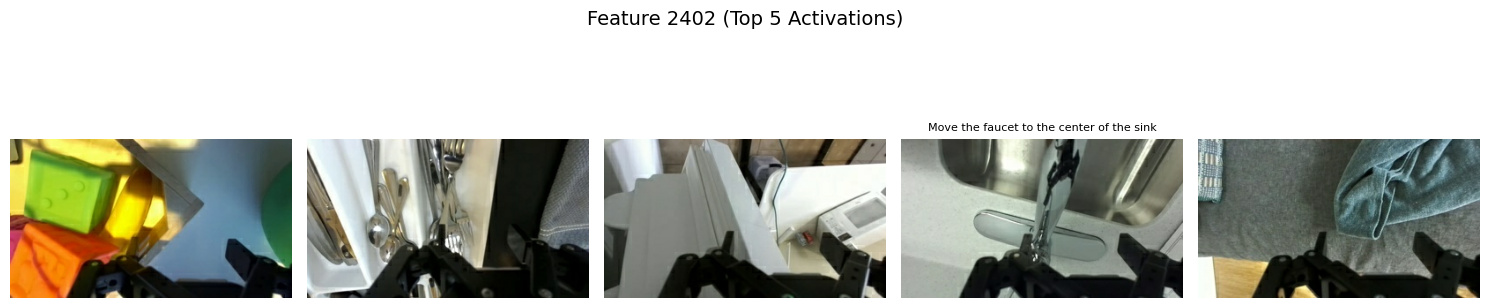

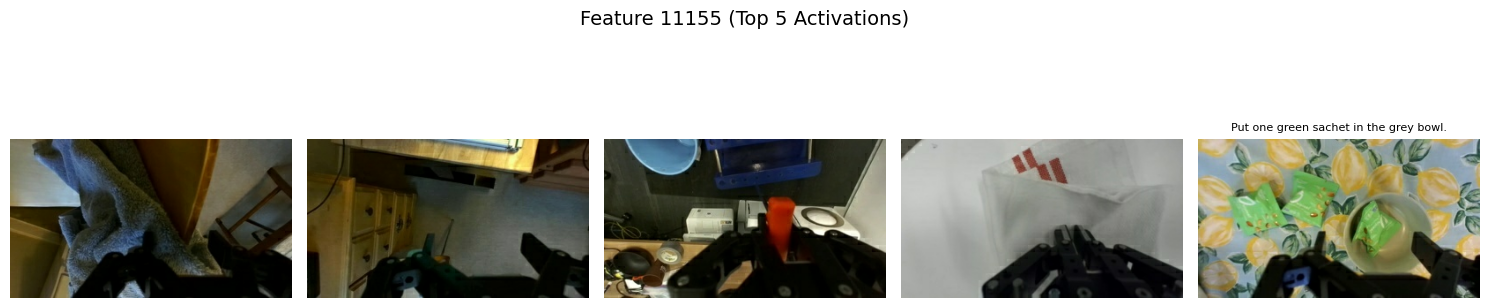

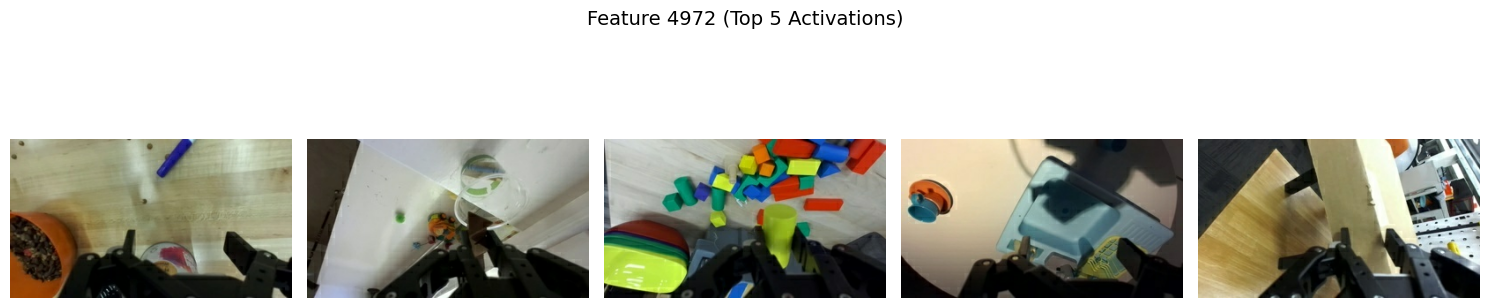

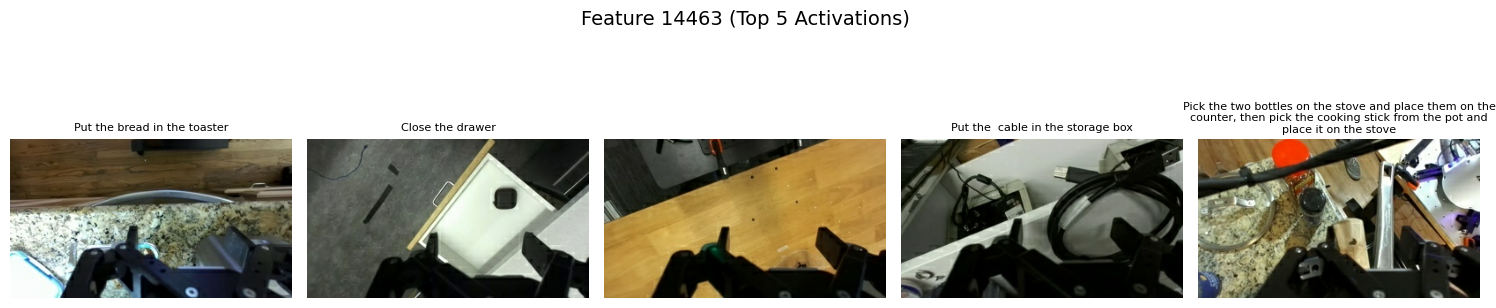

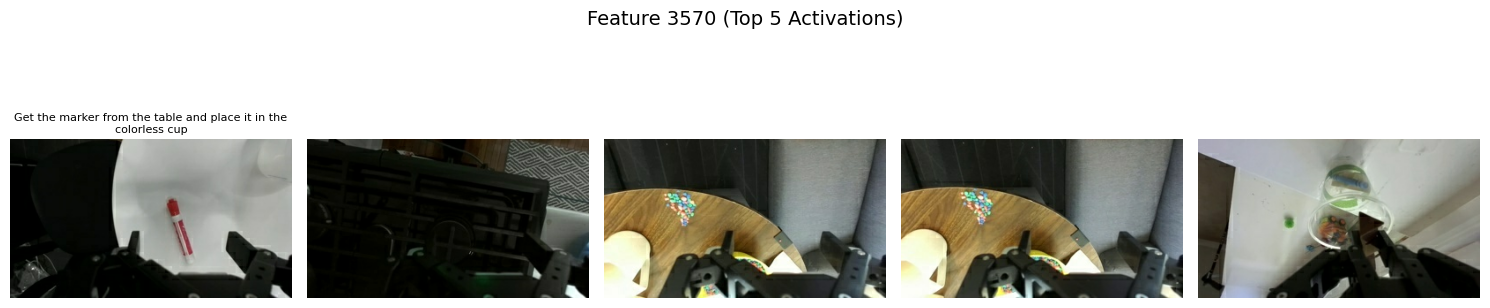

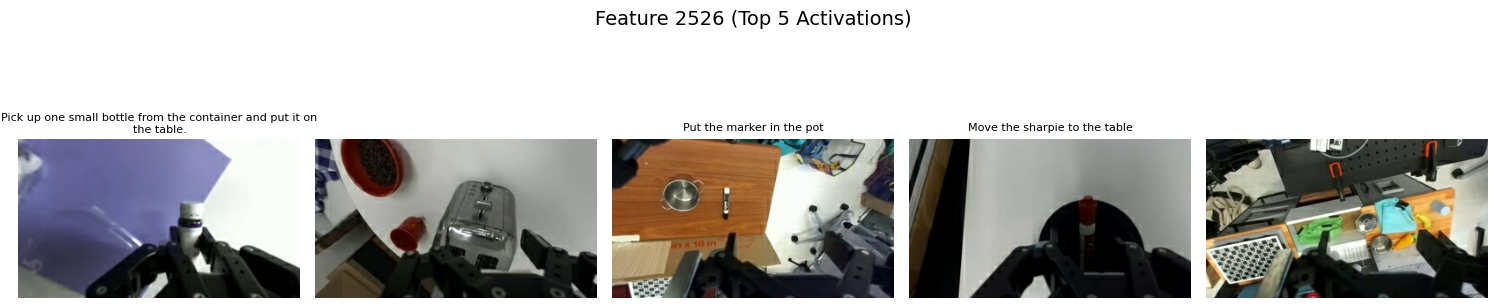

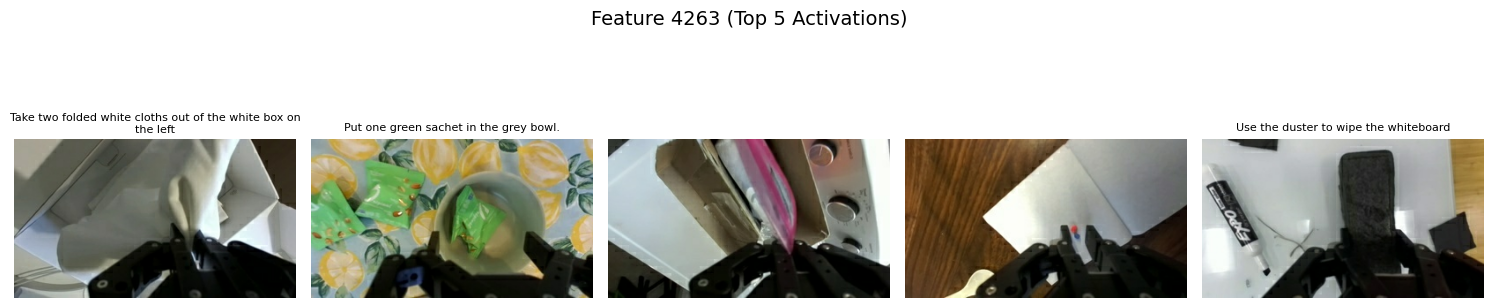

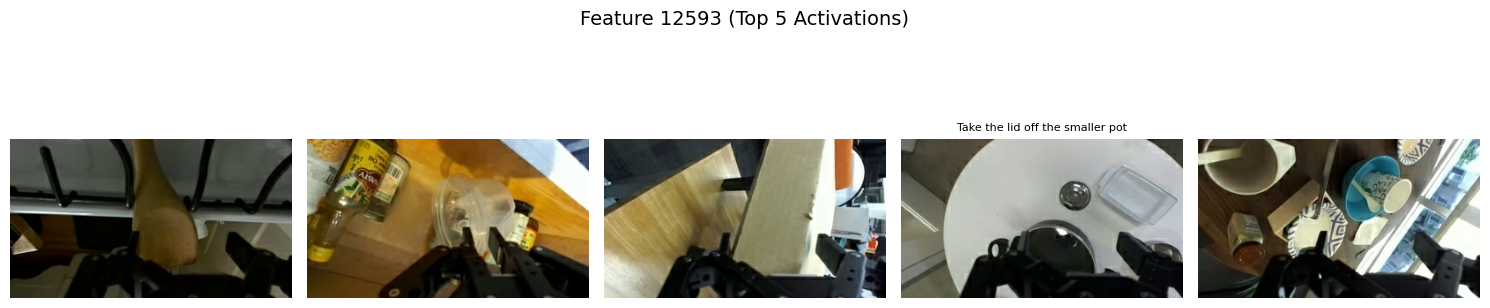

In [25]:
from torchvision.transforms.functional import to_pil_image
from concurrent.futures import ThreadPoolExecutor
import matplotlib.pyplot as plt
import numpy as np

# ==== CONFIG ====
top_k = 5
n_features_to_plot = 15
batch_size = 4096
num_workers = 8

# ==== STREAM ENCODE ====
sparse_feature_list = []
running_sum = torch.zeros(sae.decoder.in_features, device=sae_device)
count = 0

with torch.no_grad():
    for i in range(0, all_activations.size(0), batch_size):
        batch = all_activations[i:i + batch_size].to(device=sae_device, dtype=sae_dtype)
        sparse = sae.activation(sae.encoder(batch))
        running_sum += sparse.sum(dim=0)
        count += sparse.size(0)
        sparse_feature_list.append(sparse.cpu())

sparse_features = torch.cat(sparse_feature_list, dim=0)

# ==== TOKEN TO IMAGE INDEX MAPPING ====
image_indices_per_token = []
for img_idx, n_tokens in enumerate(image_to_token_counts):
    image_indices_per_token.extend([img_idx] * n_tokens)
image_indices_per_token = np.array(image_indices_per_token)

# ==== TOP FEATURES ====
mean_features = running_sum / count
top_features = torch.topk(mean_features, k=n_features_to_plot).indices.tolist()
print(f"Top {n_features_to_plot} active features:", top_features)

# ==== IMAGE & TEXT LOADER ====
def load_img_and_text(idx):
    img_idx = int(image_indices_per_token[idx])
    entry = dataset[img_idx]
    # Convert image tensor to PIL and then to numpy for plotting
    image_tensor = entry["image"]
    image_pil = to_pil_image(image_tensor)
    prompt = entry["prompt"]
    return np.array(image_pil), prompt

# ==== DISPLAY LOOP ====
for feature_idx in top_features:
    activations = sparse_features[:, feature_idx]
    topk_indices = torch.topk(activations, k=top_k).indices.cpu().tolist()

    # Load image-prompt pairs
    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        img_and_text = list(executor.map(load_img_and_text, topk_indices))

    images, prompts = zip(*img_and_text)

    # Plot results
    fig, axes = plt.subplots(1, top_k, figsize=(3 * top_k, 4))
    fig.suptitle(f"Feature {feature_idx} (Top {top_k} Activations)", fontsize=14)

    for ax, img, text in zip(axes, images, prompts):
        ax.imshow(img)
        ax.set_title(text, fontsize=8, wrap=True)
        ax.axis("off")

    plt.tight_layout()
    plt.show()

### Sparsity analysis

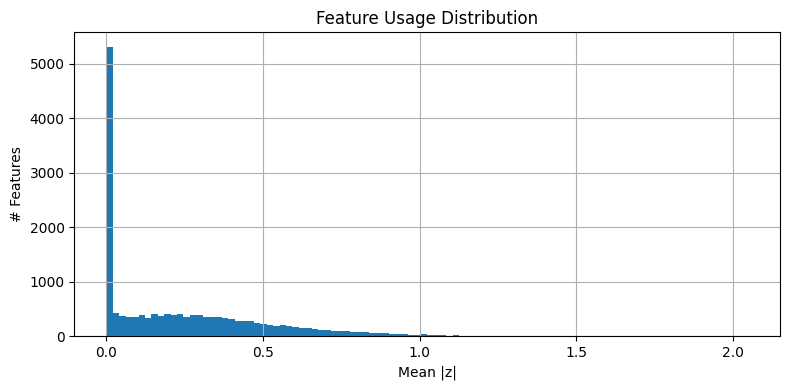

In [26]:
# Assume `sae` is already loaded and on the correct device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
sae = sae.to(device)
sae.eval()

# Compute feature usage (mean |z|) without storing all z
d_hidden = sae.module.encoder.out_features if isinstance(sae, torch.nn.DataParallel) else sae.encoder.out_features
running_sum = torch.zeros(d_hidden, device=device)
count = 0

with torch.no_grad():
    for (batch,) in train_loader:
        batch = batch.to(device, non_blocking=True)
        _, z = sae(batch)                      # shape: [B, d_hidden] or [B, T, d_hidden]
        z = z.view(-1, z.shape[-1])            # flatten in case it's [B, T, d_hidden]
        running_sum += torch.sum(torch.abs(z), dim=0)
        count += z.shape[0]

feature_usage = running_sum / count

# Plot
plt.figure(figsize=(8, 4))
plt.hist(feature_usage.cpu().numpy(), bins=100)
plt.title("Feature Usage Distribution")
plt.xlabel("Mean |z|")
plt.ylabel("# Features")
plt.grid(True)
plt.tight_layout()
plt.show()


### Clean up memory

In [12]:
# del [insert variable]
del d_hidden
torch.cuda.empty_cache()
gc.collect()

650